# Lab 8: Bayes Decision Models Evaluation

In [5]:
# import
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import sklearn as sk
import nbimporter 
from lab7 import calc_logl
# note: it is necessarey to install nbimporter and nbformat before importing it (pip install ~)

In [6]:
# Utilities
def labels_to_num(l):
    if l == 'Iris-setosa':
        retval = 0
    elif l == "Iris-versicolor":
        retval = 1
    elif l == "Iris-virginica":
        retval = 2
    return retval

def num_to_labels(l):
    if l == 0:
        retval = "Iris-setosa"
    elif l == 1:
        retval = "Iris-versicolor"
    elif l == 2:
        retval = "Iris-virginica"
    return retval

def vcol(v):
    return np.array(v).reshape(v.size, 1)
def vrow(v):
    return np.array(v).reshape(1, v.size)



In [7]:
# Gaussian classifier (flom lab 6)

# compute the logdensity for a sample x:
def logpdf_GAU_ND(x, mu, C):
    # M = numbers of dimensions
    M = mu.shape[0]
    # N = number of values
    N = x.shape[1]
    C_inv = linalg.inv(C)
    log_N = np.zeros(N)
    _, logdet_C = np.linalg.slogdet(C)
   
    for i in range(N):
        x_i = vcol(x[:, i])
        log_N[i] = (-M/2 * np.log(2 * np.pi) - 0.5 * logdet_C - 0.5 * (x_i - mu).T @ C_inv @ (x_i - mu)).item()
   
    return np.array(log_N)

def loglikelihood(x, mu_ML, C_ML):
    return np.sum(logpdf_GAU_ND(x, mu_ML, C_ML))

# random stuff
def load_iris():
    D,L = sklearn.datasets.load_iris()['data'].T, sklearn.datasets.load_iris()['target']
    return D, L


def split_db_2to1(D, L, seed=0):
    nTrain = int(D.shape[1]*2.0/3.0)
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1])
    idxTrain = idx[0:nTrain]
    idxTest = idx[nTrain:]
    DTR = D[:, idxTrain]
    DTE = D[:, idxTest]
    LTR = L[idxTrain]
    LTE = L[idxTest]
    return (DTR, LTR), (DTE, LTE)

# Data
D, L = load_iris()
# DTR and LTR are training data and labels, DTE and LTE are evaluation 
# (or more precisely validation) data and labels
(DTR, LTR), (DTE, LTE) = split_db_2to1(D, L)
# We use 100 samples for training and 50 samples for evaluation.

# Calculate ML parameters
mu = np.zeros([4, 3])
C = np.zeros([3, 4 , 4])

for l in range(3):
    x_c = DTR[:, LTR == l]
    N_c = x_c.shape[1]
    mu[:, l] = np.mean(x_c, 1)
    delta = x_c - vcol(mu[:, l])
    C[l, :, :] = delta @ delta.T / N_c

# Calculate likelihood 

# S => "scores" matrix
S = np.zeros([3, DTE.shape[1]])

for i in range(3):
    for j in range(S.shape[1]):
        S[i, j] = np.exp(loglikelihood(vcol(DTE[:, j]), vcol(mu[:, i]), C[i, :, :]))

# calculate S_joint and posterior probability
S_joint = S/3
S_marginal = vrow(S_joint.sum(0))

S_post = S_joint / S_marginal
L_pred = S_post.argmax(0)

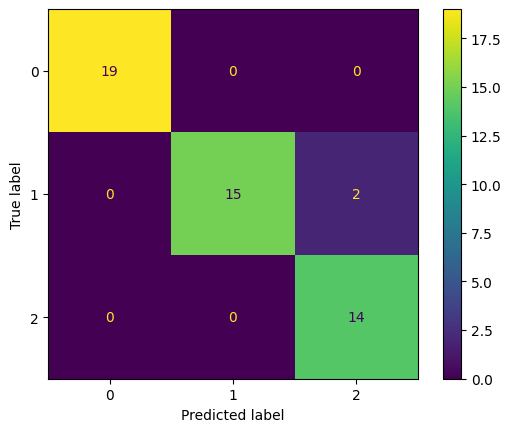

In [8]:
# Computing confusion matrix: (missclassification cost always == 1)
confusion_matrix = sklearn.metrics.confusion_matrix(LTE, L_pred)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2])
cm_display.plot()
plt.show()


Given the limited number of errors, a detailed analysis of the IRIS dataset is not particularly insightful. We therefore shift our focus to a larger evaluation dataset.

In the following, we will use the outputs of the classifier developed in Laboratory 7. This classifier provides class-conditional log-likelihoods. You can load the log-likelihood matrix and the corresponding tercet labels from Data/commedia_ll.npy and Data/commedia_labels.npy.

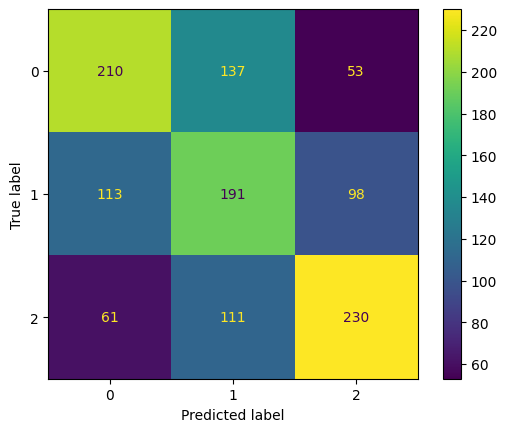

In [9]:
# confusion matrix based on lab7
S = np.load("./Data/commedia_ll.npy")# log likelyhood
actual_labels = np.load("./Data/commedia_labels.npy")

S_joint = np.exp(S) * 1/3
S_marginal = vrow(S_joint.sum(0))

S_post = S_joint/S_marginal
L_pred = S_post.argmax(0)

# Computing confusion matrix: (missclassification cost always == 1)
confusion_matrix = sklearn.metrics.confusion_matrix(actual_labels, L_pred)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2])
cm_display.plot()
plt.show()

We now consider the binary Inferno-vs-Paradiso task of Laboratory 7. The
classifier output consists of an array of log-likelihood ratios. You can load the LLRs from Data/com-
media_llr_infpar.npy . The corresponding labels are in Data/commedia_labels_infpar.npy .
In the following we assume that label HT corresponds to the Inferno and HF to the Paradiso class.

Write a function that computes optimal Bayes decisions for different priors and costs starting from binary
log-likelihood ratios. The function should receive the triplet (π1, Cf n, Cf p), corresponding to the cost
matrix

In [10]:
# optimal bayes decision

#load data
llr_infpar = np.load("Data/commedia_llr_infpar.npy")        # loglikelihood ratios
actual_labels = np.load("Data/commedia_labels_infpar.npy")

In [11]:
def optimal_bayes_decision(llr_list, pi, Cfn, Cfp): # note llr is considered a vector
    true = pi
    false = 1 - pi
    result_list = np.zeros(len(llr_list))
    i = 0
    for llr in llr_list:
        t = -np.log( (true*Cfn) / (false*Cfp) )
        result_list[i] = 1 if llr > t else 0
        i += 1
    return result_list

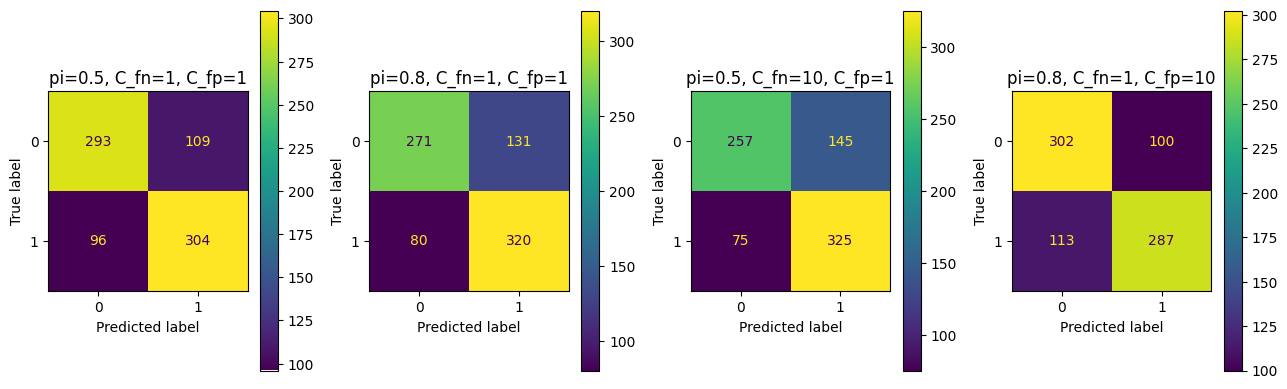

In [12]:

pi = [0.5, 0.8, 0.5, 0.8]
Cfn = [1, 1, 10, 1]
Cfp = [1, 1, 1, 10]
predicted_labels = np.zeros([4, len(llr_infpar)])

fig, axes = plt.subplots(1, 4, figsize=(13, 4))

for i in range(4):
    predicted_labels[i, :] = vrow(optimal_bayes_decision(llr_infpar, pi[i], Cfn[i], Cfp[i]))
    confusion_matrix = sklearn.metrics.confusion_matrix(actual_labels, predicted_labels[i, :])

    cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
    
    cm_display.plot(ax = axes[i])
    axes[i].set_title(f"pi={pi[i]}, C_fn={Cfn[i]}, C_fp={Cfp[i]}")

plt.tight_layout()
plt.show()

## Binary task: evaluation

In [13]:
def detection_cost_function(confusion_matrix, pi, Cfn, Cfp):
    false_negative = confusion_matrix[1, 0]
    true_negative = confusion_matrix[0, 0]
    false_positive = confusion_matrix[0, 1]
    true_positive = confusion_matrix[1, 1]
    false_negative_rate = false_negative / (false_negative + true_positive)
    false_positive_rate = false_positive / (false_positive + true_negative)

    return pi*Cfn*false_negative_rate + (1 - pi)*Cfp*false_positive_rate

def compute_normalized_dcf(predicted_labels, actual_labels, pi, Cfn, Cfp):
    dcf_list = []
    for i in range(len(pi)):
        confusion_matrix = sklearn.metrics.confusion_matrix(actual_labels, predicted_labels[i, :])
        DCF = detection_cost_function(confusion_matrix, pi[i], Cfn[i], Cfp[i])/np.min([pi[i]*Cfn[i], (1-pi[i])*Cfp[i]])
        dcf_list.append(DCF)
    return dcf_list

In [14]:
for i in range(4):
    confusion_matrix = confusion_matrix = sklearn.metrics.confusion_matrix(actual_labels, predicted_labels[i, :])
    DCF = detection_cost_function(confusion_matrix, pi[i], Cfn[i], Cfp[i])
    print(f"DCF(pi: {pi[i]}, Cfn: {Cfn[i]}, Cfp:{Cfp[i]}) = {DCF}")

DCF(pi: 0.5, Cfn: 1, Cfp:1) = 0.25557213930348255
DCF(pi: 0.8, Cfn: 1, Cfp:1) = 0.22517412935323383
DCF(pi: 0.5, Cfn: 10, Cfp:1) = 1.1178482587064678
DCF(pi: 0.8, Cfn: 1, Cfp:10) = 0.7235124378109452


The Bayes risk allows us comparing different systems, however it does not tell us what is the benefit of
using our recognizer with respect to optimal decisions based on prior information only. We can compute
a normalized detection cost, by dividing the Bayes risk by the risk of an optimal system that does not
use the test data at all. We have seen that the cost of such system is $B_{dummy} = min(\pi C_{fn},(1-pi) C_{fp})$

In [15]:
dcf_list = compute_normalized_dcf(predicted_labels, actual_labels, pi, Cfn, Cfp)
for i in range(len(dcf_list)):
    print(f"DCF(pi: {pi[i]}, Cfn: {Cfn[i]}, Cfp:{Cfp[i]}) = {dcf_list[i]}")

DCF(pi: 0.5, Cfn: 1, Cfp:1) = 0.5111442786069651
DCF(pi: 0.8, Cfn: 1, Cfp:1) = 1.1258706467661694
DCF(pi: 0.5, Cfn: 10, Cfp:1) = 2.2356965174129355
DCF(pi: 0.8, Cfn: 1, Cfp:10) = 0.9043905472636815


## Minimun detection cost
We have seen during the lectures that, for binary tasks, we can measure the contribution to the cost due
to poor class separation and the contribution due to poor score calibration: our classifier does not produce outputs that represent log-likelihood ratios, thus the theoretical threshold is not optimal anymore
(note that this happens even for generative models — for example, the model parameters may not be
consistent between training and test population).


Scores can be re-calibrated by using a (small) set of labeled samples, that behave similarly to the eval-
uation population and were not used for model training (i.e. a validation set). Alternatively, we can
compute the optimal threshold for a given application on the same validation set, and use such threshold
for the test population (K-fold cross validation can be also exploited to extract validation sets from the
training data when validation data is not available).


Even if we do not have such data available, it may still be interesting knowing how good the model would
perform if we had selected the best possible threshold. To this extent, we can compute the (normalized)
DCF over the test set using all possible thresholds, and select its minimum value. This represents a
lower bound for the DCF that our system can achieve (minimum DCF in the following).

To compute the minimum cost, consider a set of thresholds corresponding to $(−∞, s_1 . . . s_M , +∞)$, where
$ s_1 . . . s_M $ are the test scores, sorted in increasing order (notice that the DCF can change only when we
change a prediction, and that can happen only when the threshold moves “across” one of the evaluation
scores). For each threshold t, compute the confusion matrix on the test set itself that would be obtained
if scores were thresholded at t, and the corresponding normalized DCF using the code developed in the
previous section. The minimum DCF is the minimum of the obtained values.

In [16]:
def compute_min_dcf(llr, n, actual_labels, pi, Cfn, Cfp):
    min_DCF_list = []
    
    for i in range(n):
        # Get sorted scores (thresholds)
        scores_sorted = np.sort(llr)
        
        # Add -inf and +inf as boundary thresholds
        thresholds = np.concatenate([[-np.inf], scores_sorted, [np.inf]])
        
        # Track minimum DCF for this configuration
        min_dcf = np.inf
        
        # For each possible threshold
        for threshold in thresholds:
            # Predict labels: 1 if score > threshold, 0 otherwise
            pred_labels = (llr > threshold).astype(int)
            
            # Compute confusion matrix
            cm = sklearn.metrics.confusion_matrix(actual_labels, pred_labels)
            
            # Compute normalized DCF
            dcf = detection_cost_function(cm, pi[i], Cfn[i], Cfp[i]) / np.min([pi[i]*Cfn[i], (1-pi[i])*Cfp[i]])
            
            # Keep track of minimum
            if dcf < min_dcf:
                min_dcf = dcf
        
        min_DCF_list.append(min_dcf)
        print(f"min-DCF(pi: {pi[i]}, Cfn: {Cfn[i]}, Cfp:{Cfp[i]}) = {min_dcf}")
    
    return min_DCF_list

# Compute minimum DCF for each configuration
min_DCF_list = compute_min_dcf(llr_infpar, 4, actual_labels, pi, Cfn, Cfp)

min-DCF(pi: 0.5, Cfn: 1, Cfp:1) = 0.5061442786069652
min-DCF(pi: 0.8, Cfn: 1, Cfp:1) = 0.7515422885572139
min-DCF(pi: 0.5, Cfn: 10, Cfp:1) = 0.8415422885572139
min-DCF(pi: 0.8, Cfn: 1, Cfp:10) = 0.70931592039801


## Roc curve
OC curves are a method to evaluate the trade-off between the different kind of errors for our recog-
nizer. ROC curves can be used, for example, to plot false positive rates versus true positive rates as the
threshold varies. Note that these plots do not account for errors due to poor selection of the threshold
(i.e. mis-calibration), since they simply plot how the error rates change when we modify the threshold
on the evaluation set.


The most commonly used ROC curves plot true positive rates against false positive rates. You can
compute true positive rates from false negative rates as Ptp = 1 − Pf n. The ROC curve consists of
points (Ptp(t), Pf p(t)) where t is the threshold. By sweeping all possible thresholds we can obtain the
coordinates of the ROC curve.
Plot the ROC curve for the 2-class problem scores (array of LLRs). For each threshold, compute the
confusion matrix and extract the Pf n and Pf p as you did in the previous section. Compute Ptp as 1−Pf n.


Plot the curve that contains, on x-axis, all the false positive rates, and on the y-axis all corresponding
true positive rates. You should obtain:

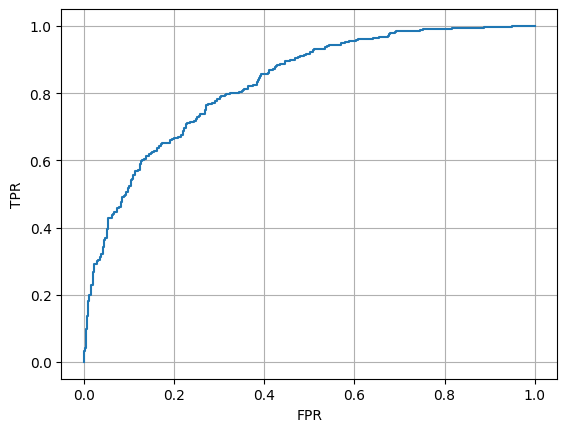

In [17]:
TPR = []
FPR = []


scores_sorted = np.sort(llr_infpar)

# Add -inf and +inf as boundary thresholds
thresholds = np.concatenate([[-np.inf], scores_sorted, [np.inf]])

# For each possible threshold
for threshold in thresholds:
    # Predict labels: 1 if score > threshold, 0 otherwise
    pred_labels = (llr_infpar > threshold).astype(int)
    
    # Compute confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(actual_labels, pred_labels)
    
    # Compute false positive rate
    false_negative = confusion_matrix[1, 0]
    true_negative = confusion_matrix[0, 0]
    false_positive = confusion_matrix[0, 1]
    true_positive = confusion_matrix[1, 1]
    false_negative_rate = false_negative / (false_negative + true_positive)
    false_positive_rate = false_positive / (false_positive + true_negative)

    # compute true positive rate
    true_positive_rate = 1 - false_negative_rate

    TPR.append(true_positive_rate)
    FPR.append(false_positive_rate)


plt.plot(FPR, TPR)
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.grid()
plt.show()
  

## Bayes Error Plots 

In [18]:
def effective_prior(p):
    return 1/(1+np.exp(-p))

In [27]:
effPriorLogOdds = np.linspace(-3, 3, 21)
pi = []
for p in effPriorLogOdds:
    pi.append(effective_prior(p))
Cfn = Cfp = vrow(np.ones(21))

predicted_labels = np.zeros([21, len(llr_infpar)])



for i in range(21):
    predicted_labels[i, :] = vrow(optimal_bayes_decision(llr_infpar, pi[i], 1, 1))
    
dcf = compute_normalized_dcf(predicted_labels, actual_labels, pi, Cfn[0], Cfp[0])
mindcf = compute_min_dcf(llr_infpar, 21, actual_labels, pi, Cfn[0], Cfp[0])


min-DCF(pi: 0.04742587317756678, Cfn: 1.0, Cfp:1.0) = 0.9675000000000001
min-DCF(pi: 0.06297335605699649, Cfn: 1.0, Cfp:1.0) = 0.9675
min-DCF(pi: 0.08317269649392238, Cfn: 1.0, Cfp:1.0) = 0.9296833470710607
min-DCF(pi: 0.10909682119561294, Cfn: 1.0, Cfp:1.0) = 0.8903246995350966
min-DCF(pi: 0.14185106490048777, Cfn: 1.0, Cfp:1.0) = 0.84293986860626
min-DCF(pi: 0.18242552380635635, Cfn: 1.0, Cfp:1.0) = 0.8078363224702552
min-DCF(pi: 0.23147521650098232, Cfn: 1.0, Cfp:1.0) = 0.7541979410452837
min-DCF(pi: 0.28905049737499605, Cfn: 1.0, Cfp:1.0) = 0.7071051453866988
min-DCF(pi: 0.35434369377420455, Cfn: 1.0, Cfp:1.0) = 0.6336643254226766
min-DCF(pi: 0.4255574831883409, Cfn: 1.0, Cfp:1.0) = 0.5721821751658712
min-DCF(pi: 0.5, Cfn: 1.0, Cfp:1.0) = 0.5061442786069652
min-DCF(pi: 0.5744425168116589, Cfn: 1.0, Cfp:1.0) = 0.5853897059502271
min-DCF(pi: 0.6456563062257954, Cfn: 1.0, Cfp:1.0) = 0.6365961058817995
min-DCF(pi: 0.7109495026250039, Cfn: 1.0, Cfp:1.0) = 0.6821224665372053
min-DCF(pi: 

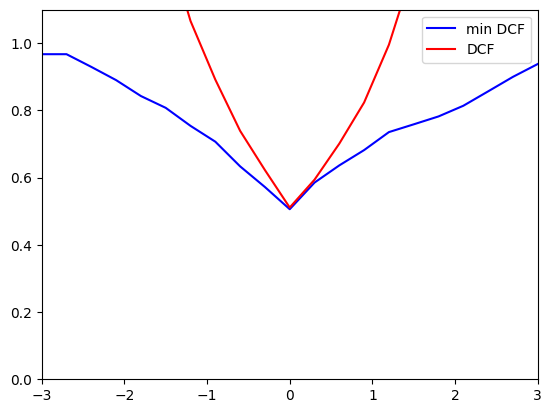

In [ ]:
# plot
plt.plot(effPriorLogOdds, mindcf, label='min DCF', color='b')
plt.plot(effPriorLogOdds, dcf, label='DCF', color='r')
plt.ylim([0, 1.1])
plt.xlim([-3, 3])
plt.legend()
plt.show()